In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import databento as db
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from scipy.stats import randint, uniform, loguniform, stats
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from datetime import datetime
import joblib
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Loading data

### LOB data

In [2]:
def load_lob_data(dates):
    dataframes = {}
    for date in dates:
        for asset in ['QQQ', 'SPY', 'FAST', 'MRVL', 'VRSK', 'VXX', 'ANSS']:
            dataframe = pd.read_parquet(f'C:/Users/Эвелина Новикова/{asset}_{date}.parquet')
            dataframe[f'best_bid_{asset}'] = dataframe['bids[0].price']
            dataframe[f'best_bid_amount_{asset}'] = dataframe['bids[0].amount']
            dataframe[f'best_ask_{asset}'] = dataframe['asks[0].price']
            dataframe[f'best_ask_amount_{asset}'] = dataframe['asks[0].amount']
            dataframe[f'mid_{asset}'] = (dataframe['bids[0].price'] + dataframe['asks[0].price'])/2
            dataframe[f'diff_mid_{asset}'] = dataframe[f'mid_{asset}'].diff().fillna(1e-12)
            dataframe[f'mid_changes_{asset}'] = dataframe[f'mid_{asset}'].diff().ne(0).rolling('1min').sum()
            dataframe[f'spread_{asset}'] = (dataframe['bids[0].price'] - dataframe['asks[0].price'])/(1e-12)
            dataframe[f'rel_spread_{asset}'] = dataframe[f'spread_{asset}']/(dataframe[f'mid_{asset}'] + 1e-12)
            dataframe[f'diff_spread_{asset}'] = dataframe[f'spread_{asset}'].diff().fillna(1e-12)
            dataframe[f'spread_changes_{asset}'] = dataframe[f'spread_{asset}'].diff().ne(0).rolling('1min').sum()
            dataframe[f'ask_volume_L5_{asset}'] = sum(dataframe[f'asks[{i}].amount'] for i in range(5))
            dataframe[f'bid_volume_L5_{asset}'] = sum(dataframe[f'bids[{i}].amount'] for i in range(5))
            dataframe[f'ask_volume_L20_{asset}'] = sum(dataframe[f'asks[{i}].amount'] for i in range(20))
            dataframe[f'bid_volume_L20_{asset}'] = sum(dataframe[f'bids[{i}].amount'] for i in range(20))
            dataframe[f'ask_volume_changes_{asset}'] = dataframe[f'ask_volume_L20_{asset}'].diff().ne(0).rolling('1min').sum()
            dataframe[f'bid_volume_changes_{asset}'] = dataframe[f'bid_volume_L20_{asset}'].diff().ne(0).rolling('1min').sum()
            dataframe[f'volume_changes_ratio_{asset}'] = (dataframe[f'bid_volume_changes_{asset}'] - dataframe[f'ask_volume_changes_{asset}'])/(dataframe[f'bid_volume_changes_{asset}'] + dataframe[f'ask_volume_changes_{asset}'] + 1e-12)
            dataframe[f'lob_imbalance_L20_{asset}'] = (dataframe[f'bid_volume_L20_{asset}'] - dataframe[f'ask_volume_L20_{asset}'])/(dataframe[f'bid_volume_L20_{asset}'] + dataframe[f'ask_volume_L20_{asset}'] + 1e-12)
            dataframe[f'lob_imbalance_L1_{asset}'] = (dataframe[f'best_bid_amount_{asset}'] - dataframe[f'best_ask_amount_{asset}'])/(dataframe[f'best_bid_amount_{asset}'] + dataframe[f'best_ask_amount_{asset}'] + 1e-12)
            dataframe[f'lob_imbalance_L5_{asset}'] = (dataframe[f'bid_volume_L5_{asset}'] - dataframe[f'ask_volume_L5_{asset}'])/(dataframe[f'bid_volume_L5_{asset}'] + dataframe[f'ask_volume_L5_{asset}'] + 1e-12)
            dataframe[f'diff_bids_{asset}'] = dataframe[f'bid_volume_L20_{asset}'].diff().fillna(1e-12)
            dataframe[f'diff_asks_{asset}'] = dataframe[f'ask_volume_L20_{asset}'].diff().fillna(1e-12)
            dataframe[f'diff_ratio_{asset}'] = (dataframe[f'diff_bids_{asset}'] - dataframe[f'diff_asks_{asset}'])/(dataframe[f'diff_bids_{asset}'] + dataframe[f'diff_asks_{asset}'] + 1e-12)
            dataframe[f'ask_weighted_price_L20_{asset}'] = sum(dataframe[f'asks[{i}].price'] * dataframe[f'asks[{i}].amount'] for i in range(20))
            dataframe[f'bid_weighted_price_L20_{asset}'] = sum(dataframe[f'bids[{i}].price'] * dataframe[f'bids[{i}].amount'] for i in range(20))
            dataframe[f'ask_weighted_price_L5_{asset}'] = sum(dataframe[f'asks[{i}].price'] * dataframe[f'asks[{i}].amount'] for i in range(5))
            dataframe[f'bid_weighted_price_L5_{asset}'] = sum(dataframe[f'bids[{i}].price'] * dataframe[f'bids[{i}].amount'] for i in range(5))
            dataframe[f'vwap_L5_{asset}'] = (dataframe[f'ask_weighted_price_L5_{asset}'] + dataframe[f'bid_weighted_price_L5_{asset}'])/(dataframe[f'ask_volume_L5_{asset}'] + dataframe[f'bid_volume_L5_{asset}'] + 1e-12)
            dataframe[f'vwap_L20_{asset}'] = (dataframe[f'ask_weighted_price_L20_{asset}'] + dataframe[f'bid_weighted_price_L20_{asset}'])/(dataframe[f'ask_volume_L20_{asset}'] + dataframe[f'bid_volume_L20_{asset}'] + 1e-12)
            dataframe[f'ask_weigh_dist_{asset}'] = sum(dataframe[f'asks[{i}].amount'] * (dataframe[f'asks[{i}].price'] - dataframe[f'mid_{asset}'])for i in range(20))
            dataframe[f'bid_weigth_dist_{asset}'] = sum(dataframe[f'bids[{i}].amount'] * (dataframe[f'mid_{asset}'] - dataframe[f'bids[{i}].price'])for i in range(20))
            dataframe[f'weigth_dist_ratio_{asset}'] = (dataframe[f'ask_weigh_dist_{asset}'] - dataframe[f'bid_weigth_dist_{asset}'])/(dataframe[f'bid_weigth_dist_{asset}'] + dataframe[f'ask_weigh_dist_{asset}'] + 1e-12)
            dataframes[f'{asset}_{date}'] = pd.DataFrame({f'mid_{asset}': dataframe[f'mid_{asset}'],
                                                          f'best_bid_{asset}': dataframe[f'best_bid_{asset}'],
                                                          f'best_ask_{asset}': dataframe[f'best_ask_{asset}'],
                                                          f'best_bid_amount_{asset}': dataframe[f'best_bid_amount_{asset}'],
                                                          f'best_ask_amount_{asset}': dataframe[f'best_ask_amount_{asset}'],
                                                          f'diff_mid_{asset}': dataframe[f'diff_mid_{asset}'],
                                                          f'mid_changes_{asset}': dataframe[f'mid_changes_{asset}'],
                                                          f'spread_{asset}': dataframe[ f'spread_{asset}'],
                                                          f'rel_spread_{asset}': dataframe[f'rel_spread_{asset}'],
                                                          f'diff_spread_{asset}': dataframe[f'diff_spread_{asset}'],
                                                          f'spread_changes_{asset}': dataframe[f'spread_changes_{asset}'],
                                                          f'volume_changes_ratio_{asset}': dataframe[f'volume_changes_ratio_{asset}'],
                                                          f'lob_imbalance_L1_{asset}': dataframe[f'lob_imbalance_L1_{asset}'],
                                                          f'lob_imbalance_L5_{asset}': dataframe[f'lob_imbalance_L5_{asset}'],
                                                          f'lob_imbalance_L20_{asset}': dataframe[f'lob_imbalance_L20_{asset}'],
                                                          f'diff_ratio_{asset}': dataframe[f'diff_ratio_{asset}'],
                                                          f'vwap_L20_{asset}': dataframe[f'vwap_L20_{asset}'],
                                                          f'vwap_L5_{asset}': dataframe[f'vwap_L5_{asset}'],
                                                          f'weigth_dist_ratio_{asset}': dataframe[f'weigth_dist_ratio_{asset}']})
 
    return dataframes

### Trades

In [3]:
def db_preparing(path: str) -> pd.DataFrame:
    store = db.DBNStore.from_file(path)
    df = store.to_df()
    df = df.reset_index(drop=True)
    trades = df[['ts_event', 'side', 'depth', 'price', 'size']]
    trades['ts_event'] = pd.to_datetime(trades['ts_event'].astype('int64'))
    trades = trades.set_index('ts_event')
    return trades

In [4]:
def resampling(path: str) -> pd.DataFrame:
    trades = db_preparing(path)
    sides = ['A', 'B', 'N']
    res_trds = []
    for side in sides:
        side_trades = trades[trades['side'] == f'{side}']
        resampled_trades = side_trades.resample("100ms").agg({"price": "mean", "size": "sum", "depth": "max"}).fillna(0)
        res_trds.append(resampled_trades['price'])
        res_trds.append(resampled_trades['size'])
    resampled_depth = trades['depth'].resample("100ms").max().fillna(0)
    res_trds.append(resampled_depth)
    trades_resampled = pd.DataFrame(res_trds).T
    trades_resampled = trades_resampled.fillna(0)
    trades_resampled.columns = ['trade_price_A', 'trade_volume_A', 'trade_price_B', 'trade_volume_B', 'trade_price_N', 'trade_volume_N', 'depth']
    return trades_resampled

In [9]:
def load_trades(dates):
    dataframes = {}
    for date in dates:
        for asset in ['QQQ', 'SPY', 'FAST', 'MRVL', 'VRSK', 'VXX', 'ANSS']:
            path = f'C:/Users/Эвелина Новикова/Downloads/xnas-itch-{date}.trades.{asset}.dbn.zst'
            dataframe = resampling(path)
            dataframe[f'buy_cnt_{asset}'] = dataframe["trade_price_B"].diff().ne(0).rolling('1min').sum()
            dataframe[f'sell_cnt_{asset}'] = dataframe["trade_price_A"].diff().ne(0).rolling('1min').sum()
            dataframe[f'buy_vol_{asset}']  = dataframe["trade_volume_B"].rolling('1min').sum()
            dataframe[f'sell_vol_{asset}']  = dataframe["trade_volume_A"].rolling('1min').sum()
            dataframe[f"cnt_imbalance_{asset}"] = (dataframe[f"buy_cnt_{asset}"] - dataframe[f"sell_cnt_{asset}"]) / (dataframe[f"buy_cnt_{asset}"] + dataframe[f"sell_cnt_{asset}"] + 1)
            dataframe[f"vol_imbalance_{asset}"] = (dataframe[f"buy_vol_{asset}"] - dataframe[f"sell_vol_{asset}"]) / (dataframe[f"buy_vol_{asset}"] + dataframe[f"sell_vol_{asset}"] + 1)
            dataframe[f"vol_imbalance_{asset}"]
            dataframes[f'{asset}_{date}'] = pd.DataFrame({f'cnt_imbalance_{asset}': dataframe[f"cnt_imbalance_{asset}"],
                                                      f'vol_imbalance_{asset}': dataframe[f"vol_imbalance_{asset}"],
                                                         f'depth_{asset}': dataframe["depth"],
                                                         f'trade_price_A_{asset}': dataframe["trade_price_A"],
                                                         f'trade_price_B_{asset}': dataframe["trade_price_B"],
                                                         f'trade_volume_A_{asset}': dataframe["trade_volume_A"],
                                                         f'trade_volume_B_{asset}': dataframe["trade_volume_B"]})
    return dataframes

In [11]:
dates = [20250630, 20250701, 20250702, 20250703]

lobs = load_lob_data(dates)
trades = load_trades(dates)

In [12]:
def make_combined_lob(date):
    combined_lob = lobs[f'VXX_{date}'].join(lobs[f'SPY_{date}'], how='outer')\
           .join(lobs[f'QQQ_{date}'], how='outer')\
           .join(lobs[f'MRVL_{date}'], how='outer')\
           .join(lobs[f'ANSS_{date}'], how='outer')\
           .join(lobs[f'FAST_{date}'], how='outer')\
           .join(lobs[f'VRSK_{date}'], how='outer')
    return combined_lob.fillna(0)

In [13]:
def make_combined_trades(date):
    combined_trades = trades[f'VXX_{date}'].join(trades[f'SPY_{date}'], how='outer')\
           .join(trades[f'QQQ_{date}'], how='outer')\
           .join(trades[f'MRVL_{date}'], how='outer')\
           .join(trades[f'ANSS_{date}'], how='outer')\
           .join(trades[f'FAST_{date}'], how='outer')\
           .join(trades[f'VRSK_{date}'], how='outer')
    return combined_trades

In [14]:
combined_lob_20250630, combined_trades_20250630 = make_combined_lob(20250630), make_combined_trades(20250630)
combined_lob_20250701, combined_trades_20250701 = make_combined_lob(20250701), make_combined_trades(20250701)
combined_lob_20250702, combined_trades_20250702 = make_combined_lob(20250702), make_combined_trades(20250702)
combined_lob_20250703, combined_trades_20250703 = make_combined_lob(20250703), make_combined_trades(20250703)

### Основная торговая сессия (13:30 - 20:00)

In [15]:
def regular_lob(combined_lob):
    combined_lob = combined_lob.reset_index()
    combined_lob['datetime'] = pd.to_datetime(combined_lob['datetime'])
    filtered_lob = combined_lob[(combined_lob['datetime'].dt.time >= pd.to_datetime('13:35:00').time()) 
                 & (combined_lob['datetime'].dt.time < pd.to_datetime('19:55:00').time())]
    return filtered_lob

In [16]:
def regular_trades(combined_trades):
    combined_trades = combined_trades.reset_index()
    combined_trades['ts_event'] = pd.to_datetime(combined_trades['ts_event'])
    filtered_trades = combined_trades[(combined_trades['ts_event'].dt.time >= pd.to_datetime('13:35:00').time()) 
                 & (combined_trades['ts_event'].dt.time < pd.to_datetime('19:55:00').time())]
    filtered_trades = filtered_trades.rename(columns={'ts_event': 'datetime'})
    return filtered_trades

In [17]:
lob_20250630 = regular_lob(combined_lob_20250630)
lob_20250701 = regular_lob(combined_lob_20250701)
lob_20250702 = regular_lob(combined_lob_20250702)
lob_20250703 = regular_lob(combined_lob_20250703)

trades_20250630 = regular_trades(combined_trades_20250630)
trades_20250701 = regular_trades(combined_trades_20250701)
trades_20250702 = regular_trades(combined_trades_20250702)
trades_20250703 = regular_trades(combined_trades_20250703)

In [18]:
concatenated_lob = pd.concat([lob_20250630, lob_20250701, lob_20250702, lob_20250703])
concatenated_lob['date'] = concatenated_lob['datetime'].dt.date
concatenated_lob['day_index'] = concatenated_lob.groupby('date').ngroup()
concatenated_lob['time'] = concatenated_lob['datetime'].dt.time

concatenated_trades = pd.concat([trades_20250630, trades_20250701, trades_20250702, trades_20250703])
concatenated_trades = concatenated_trades.set_index('datetime').fillna(0)

In [25]:
concatenated_lob.head()

,datetime,mid_VXX,best_bid_VXX,best_ask_VXX,best_bid_amount_VXX,best_ask_amount_VXX,diff_mid_VXX,mid_changes_VXX,spread_VXX,rel_spread_VXX,...,lob_imbalance_L1_VRSK,lob_imbalance_L5_VRSK,lob_imbalance_L20_VRSK,diff_ratio_VRSK,vwap_L20_VRSK,vwap_L5_VRSK,weigth_dist_ratio_VRSK,date,day_index,time
200999,2025-06-30 13:35:00.000,47.855000,47.835,47.875000,1000.0,700.0,-0.020000,63.0,-4.000000e+10,-8.358583e+08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2025-06-30,0,13:35:00
201000,2025-06-30 13:35:00.100,47.855000,47.840,47.870000,400.0,200.0,0.000000,63.0,-3.000000e+10,-6.268937e+08,...,-0.904762,-0.770833,-0.459979,-0.459979,310.463693,309.486354,0.642647,2025-06-30,0,13:35:00.100000
201001,2025-06-30 13:35:00.200,47.855000,47.840,47.870000,400.0,200.0,0.000000,63.0,-3.000000e+10,-6.268937e+08,...,-0.964583,-0.832662,-0.503503,-0.509169,310.470401,309.422586,0.662335,2025-06-30,0,13:35:00.200000
201002,2025-06-30 13:35:00.300,47.856923,47.840,47.873846,650.0,450.0,0.001923,64.0,-3.384615e+10,-7.072363e+08,...,0.000000,0.000000,0.000000,-0.503503,0.000000,0.000000,0.000000,2025-06-30,0,13:35:00.300000
201003,2025-06-30 13:35:00.400,47.860000,47.840,47.880000,200.0,200.0,0.003077,65.0,-4.000000e+10,-8.357710e+08,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2025-06-30,0,13:35:00.400000


In [26]:
concatenated_trades.head()

,cnt_imbalance_VXX,vol_imbalance_VXX,depth_VXX,trade_price_A_VXX,trade_price_B_VXX,trade_volume_A_VXX,trade_volume_B_VXX,cnt_imbalance_SPY,vol_imbalance_SPY,depth_SPY,...,trade_price_B_FAST,trade_volume_A_FAST,trade_volume_B_FAST,cnt_imbalance_VRSK,vol_imbalance_VRSK,depth_VRSK,trade_price_A_VRSK,trade_price_B_VRSK,trade_volume_A_VRSK,trade_volume_B_VRSK
datetime,,,,,,,,,,,,,,,,,,,,,
2025-06-30 13:35:00.000,-0.357143,-0.702916,0.0,0.0,0.0,0.0,0.0,-0.013304,0.079352,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-30 13:35:00.100,-0.357143,-0.702916,0.0,0.0,0.0,0.0,0.0,-0.013304,0.079577,0.0,...,41.98,0.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-30 13:35:00.200,-0.357143,-0.702916,0.0,0.0,0.0,0.0,0.0,-0.013304,0.077085,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-30 13:35:00.300,-0.357143,-0.702916,0.0,0.0,0.0,0.0,0.0,-0.015487,0.072300,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-06-30 13:35:00.400,-0.357143,-0.702916,0.0,0.0,0.0,0.0,0.0,-0.019912,0.068387,0.0,...,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
def extract_features(lob, trades):
    total_features = {}
    for asset in ['QQQ', 'SPY', 'FAST', 'MRVL', 'VRSK', 'VXX', 'ANSS']:
        best_bid = lob[f'best_bid_{asset}'].values
        best_ask = lob[f'best_ask_{asset}'].values
        best_bid_amount = lob[f'best_bid_amount_{asset}'].values
        best_ask_amount = lob[f'best_ask_amount_{asset}'].values
        mid = lob[f'mid_{asset}']
        spread = lob[f'spread_{asset}']
        tpA = trades[f'trade_price_A_{asset}'].values
        tvA = trades[f'trade_volume_A_{asset}'].values
        tpB = trades[f'trade_price_B_{asset}'].values
        tvB = trades[f'trade_volume_B_{asset}'].values
        aggr_A = tvA / (best_ask_amount + 1e-12)
        aggr_B = tvB / (best_bid_amount + 1e-12)
        dist_mid_A = np.where(tvA > 0, tpA - mid, 0.0)
        dist_mid_B = np.where(tvB > 0, mid - tpB, 0.0)
        pressure = (tvA - tvB) / (best_bid_amount + best_ask_amount + 1e-12)
        microprice = (best_ask * best_bid_amount + best_bid * best_ask_amount) / (best_bid_amount + best_ask_amount + 1e-12)
        features = pd.DataFrame({f'aggr_A_{asset}': aggr_A, f'aggr_B_{asset}': aggr_B, f'dist_mid_A_{asset}': dist_mid_A,
                                                          f'dist_mid_B_{asset}': dist_mid_B, f'pressure_{asset}': pressure,
                                                          f'microprice_{asset}': microprice}, index=concatenated_lob.index)
        features['datetime'] = lob['datetime']
        features = features.set_index('datetime')
        total_features[f'{asset}'] = features
    return total_features

In [20]:
total_features = extract_features(concatenated_lob, concatenated_trades)
concatenated_lob = concatenated_lob.set_index('datetime')
features = concatenated_lob.join(concatenated_trades, how='outer')
for asset in ['QQQ', 'SPY', 'FAST', 'MRVL', 'VRSK', 'VXX', 'ANSS']: 
    features[[f'aggr_A_{asset}', f'aggr_B_{asset}', f'dist_mid_A_{asset}',
              f'dist_mid_B_{asset}', f'pressure_{asset}', f'microprice_{asset}']] = total_features[f'{asset}']

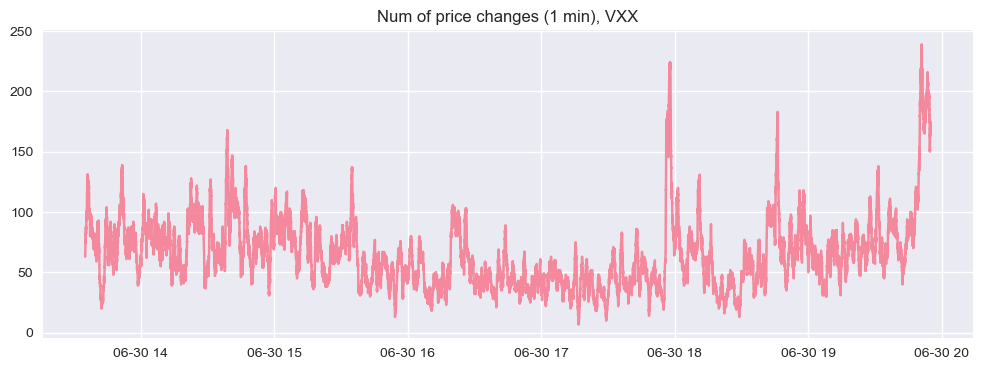

In [103]:
plt.figure(figsize=(12, 4))
plt.plot(features[features['day_index'] == 0]['mid_changes_VXX'], alpha=0.8)
plt.title('Num of price changes (1 min), VXX')
plt.grid(True)
plt.show()

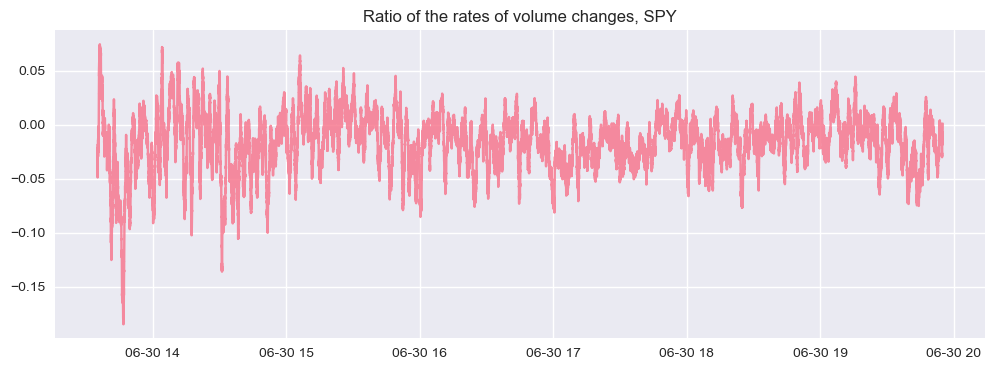

In [105]:
plt.figure(figsize=(12, 4))
plt.plot(features[features['day_index'] == 0]['volume_changes_ratio_SPY'], alpha=0.8)
plt.title('Ratio of the rates of volume changes, SPY')
plt.grid(True)
plt.show()

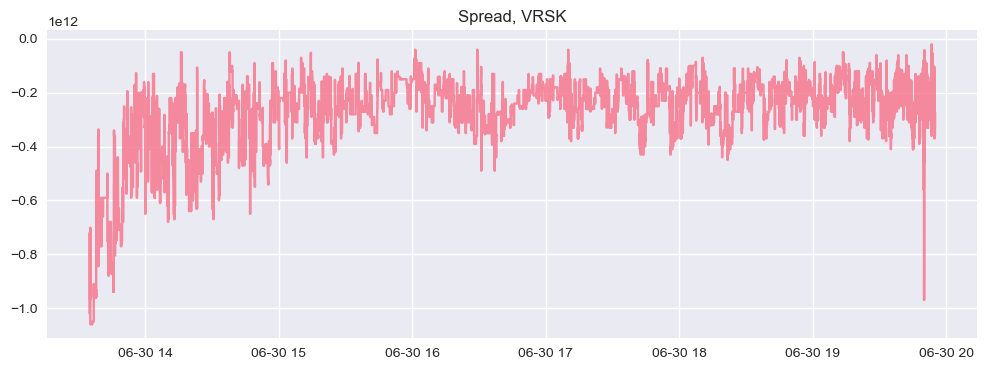

In [107]:
plt.figure(figsize=(12, 4))
plt.plot(features[features['day_index'] == 0]['spread_VRSK'], alpha=0.8)
plt.title('Spread, VRSK')
plt.grid(True)
plt.show()

In [21]:
X = features[features['time'] != features['time'].values[len(features)-1]]
y = features[features['time'] != features['time'].values[0]]

In [22]:
y_SPY = y['mid_SPY']
X_1_SPY = X[['lob_imbalance_L1_SPY', 'mid_SPY']]

y_QQQ = y['mid_QQQ']
X_1_QQQ = X[['lob_imbalance_L1_QQQ', 'mid_QQQ']]

y_VXX = y['mid_VXX']
X_1_VXX = X[['lob_imbalance_L1_VXX', 'mid_VXX']]

y_VRSK = y['mid_VRSK']
X_1_VRSK = X[['lob_imbalance_L1_VRSK', 'mid_VRSK']]

y_MRVL = y['mid_MRVL']
X_1_MRVL = X[['lob_imbalance_L1_MRVL', 'mid_MRVL']]

y_FAST = y['mid_FAST']
X_1_FAST = X[['lob_imbalance_L1_FAST', 'mid_FAST']]

y_ANSS = y['mid_ANSS']
X_1_ANSS = X[['lob_imbalance_L1_ANSS', 'mid_ANSS']]

In [23]:
X_1_SPY_train = X_1_SPY.iloc[:round(len(X_1_SPY)*0.8), :]
X_1_SPY_test = X_1_SPY.iloc[round(len(X_1_SPY)*0.8):, :]

y_SPY_train = y_SPY[:round(len(X_1_SPY)*0.8)]
y_SPY_test = y_SPY[round(len(X_1_SPY)*0.8):]

X_1_QQQ_train = X_1_QQQ.iloc[:round(len(X_1_QQQ)*0.8), :]
X_1_QQQ_test = X_1_QQQ.iloc[round(len(X_1_QQQ)*0.8):, :]

y_QQQ_train = y_QQQ[:round(len(X_1_QQQ)*0.8)]
y_QQQ_test = y_QQQ[round(len(X_1_QQQ)*0.8):]

X_1_VXX_train = X_1_VXX.iloc[:round(len(X_1_VXX)*0.8), :]
X_1_VXX_test  = X_1_VXX.iloc[round(len(X_1_VXX)*0.8):, :]

y_VXX_train = y_VXX[:round(len(X_1_VXX)*0.8)]
y_VXX_test  = y_VXX[round(len(X_1_VXX)*0.8):]

X_1_VRSK_train = X_1_VRSK.iloc[:round(len(X_1_VRSK)*0.8), :]
X_1_VRSK_test  = X_1_VRSK.iloc[round(len(X_1_VRSK)*0.8):, :]

y_VRSK_train = y_VRSK[:round(len(X_1_VRSK)*0.8)]
y_VRSK_test  = y_VRSK[round(len(X_1_VRSK)*0.8):]

X_1_MRVL_train = X_1_MRVL.iloc[:round(len(X_1_MRVL)*0.8), :]
X_1_MRVL_test  = X_1_MRVL.iloc[round(len(X_1_MRVL)*0.8):, :]

y_MRVL_train = y_MRVL[:round(len(X_1_MRVL)*0.8)]
y_MRVL_test  = y_MRVL[round(len(X_1_MRVL)*0.8):]

X_1_FAST_train = X_1_FAST.iloc[:round(len(X_1_FAST)*0.8), :]
X_1_FAST_test  = X_1_FAST.iloc[round(len(X_1_FAST)*0.8):, :]

y_FAST_train = y_FAST[:round(len(X_1_FAST)*0.8)]
y_FAST_test  = y_FAST[round(len(X_1_FAST)*0.8):]

X_1_ANSS_train = X_1_ANSS.iloc[:round(len(X_1_ANSS)*0.8), :]
X_1_ANSS_test  = X_1_ANSS.iloc[round(len(X_1_ANSS)*0.8):, :]

y_ANSS_train = y_ANSS[:round(len(X_1_ANSS)*0.8)]
y_ANSS_test  = y_ANSS[round(len(X_1_ANSS)*0.8):]

In [24]:
X_2_QQQ = X[['mid_VXX', 'mid_SPY', 'mid_QQQ', 'best_bid_QQQ', 'best_ask_QQQ', 'best_bid_amount_QQQ', 'best_ask_amount_QQQ', 'diff_mid_QQQ', 'mid_changes_QQQ',
             'spread_QQQ', 'rel_spread_QQQ', 'diff_spread_QQQ', 'spread_changes_QQQ', 'volume_changes_ratio_QQQ', 'lob_imbalance_L1_QQQ',
            'lob_imbalance_L5_QQQ', 'lob_imbalance_L20_QQQ', 'diff_ratio_QQQ', 'vwap_L20_QQQ', 'vwap_L5_QQQ', 'weigth_dist_ratio_QQQ', 'aggr_A_QQQ',
             'aggr_B_QQQ', 'dist_mid_A_QQQ', 'dist_mid_B_QQQ', 'pressure_QQQ', 'microprice_QQQ', 'cnt_imbalance_QQQ', 'vol_imbalance_QQQ', 
            'depth_QQQ', 'trade_price_A_QQQ', 'trade_price_B_QQQ', 'trade_volume_A_QQQ', 'trade_volume_B_QQQ']]

X_2_SPY = X[['mid_VXX', 'mid_SPY', 'mid_QQQ', 'best_bid_SPY', 'best_ask_SPY', 'best_bid_amount_SPY', 'best_ask_amount_SPY',
             'diff_mid_SPY', 'mid_changes_SPY', 'spread_SPY', 'rel_spread_SPY', 'diff_spread_SPY',
             'spread_changes_SPY', 'volume_changes_ratio_SPY', 'lob_imbalance_L1_SPY',
             'lob_imbalance_L5_SPY', 'lob_imbalance_L20_SPY', 'diff_ratio_SPY', 'vwap_L20_SPY',
             'vwap_L5_SPY', 'weigth_dist_ratio_SPY', 'aggr_A_SPY', 'aggr_B_SPY',
             'dist_mid_A_SPY', 'dist_mid_B_SPY', 'pressure_SPY', 'microprice_SPY',
             'cnt_imbalance_SPY', 'vol_imbalance_SPY', 'depth_SPY', 'trade_price_A_SPY',
             'trade_price_B_SPY', 'trade_volume_A_SPY', 'trade_volume_B_SPY']]

X_2_VXX = X[['mid_VXX', 'mid_SPY', 'mid_QQQ', 'best_bid_VXX', 'best_ask_VXX', 'best_bid_amount_VXX', 'best_ask_amount_VXX',
             'diff_mid_VXX', 'mid_changes_VXX', 'spread_VXX', 'rel_spread_VXX', 'diff_spread_VXX',
             'spread_changes_VXX', 'volume_changes_ratio_VXX', 'lob_imbalance_L1_VXX',
             'lob_imbalance_L5_VXX', 'lob_imbalance_L20_VXX', 'diff_ratio_VXX', 'vwap_L20_VXX',
             'vwap_L5_VXX', 'weigth_dist_ratio_VXX', 'aggr_A_VXX', 'aggr_B_VXX',
             'dist_mid_A_VXX', 'dist_mid_B_VXX', 'pressure_VXX', 'microprice_VXX',
             'cnt_imbalance_VXX', 'vol_imbalance_VXX', 'depth_VXX', 'trade_price_A_VXX',
             'trade_price_B_VXX', 'trade_volume_A_VXX', 'trade_volume_B_VXX']]

X_2_VRSK = X[['mid_VXX', 'mid_SPY', 'mid_QQQ', 'mid_VRSK', 'best_bid_VRSK', 'best_ask_VRSK', 'best_bid_amount_VRSK', 'best_ask_amount_VRSK',
              'diff_mid_VRSK', 'mid_changes_VRSK', 'spread_VRSK', 'rel_spread_VRSK', 'diff_spread_VRSK',
              'spread_changes_VRSK', 'volume_changes_ratio_VRSK', 'lob_imbalance_L1_VRSK',
              'lob_imbalance_L5_VRSK', 'lob_imbalance_L20_VRSK', 'diff_ratio_VRSK', 'vwap_L20_VRSK',
              'vwap_L5_VRSK', 'weigth_dist_ratio_VRSK', 'aggr_A_VRSK', 'aggr_B_VRSK',
              'dist_mid_A_VRSK', 'dist_mid_B_VRSK', 'pressure_VRSK', 'microprice_VRSK',
              'cnt_imbalance_VRSK', 'vol_imbalance_VRSK', 'depth_VRSK', 'trade_price_A_VRSK',
              'trade_price_B_VRSK', 'trade_volume_A_VRSK', 'trade_volume_B_VRSK']]

X_2_MRVL = X[['mid_VXX', 'mid_SPY', 'mid_QQQ', 'mid_MRVL', 'best_bid_MRVL', 'best_ask_MRVL', 'best_bid_amount_MRVL', 'best_ask_amount_MRVL',
              'diff_mid_MRVL', 'mid_changes_MRVL', 'spread_MRVL', 'rel_spread_MRVL', 'diff_spread_MRVL',
              'spread_changes_MRVL', 'volume_changes_ratio_MRVL', 'lob_imbalance_L1_MRVL',
              'lob_imbalance_L5_MRVL', 'lob_imbalance_L20_MRVL', 'diff_ratio_MRVL', 'vwap_L20_MRVL',
              'vwap_L5_MRVL', 'weigth_dist_ratio_MRVL', 'aggr_A_MRVL', 'aggr_B_MRVL',
              'dist_mid_A_MRVL', 'dist_mid_B_MRVL', 'pressure_MRVL', 'microprice_MRVL',
              'cnt_imbalance_MRVL', 'vol_imbalance_MRVL', 'depth_MRVL', 'trade_price_A_MRVL',
              'trade_price_B_MRVL', 'trade_volume_A_MRVL', 'trade_volume_B_MRVL']]

X_2_ANSS = X[['mid_VXX', 'mid_SPY', 'mid_QQQ', 'mid_ANSS', 'best_bid_ANSS', 'best_ask_ANSS', 'best_bid_amount_ANSS', 'best_ask_amount_ANSS',
              'diff_mid_ANSS', 'mid_changes_ANSS', 'spread_ANSS', 'rel_spread_ANSS', 'diff_spread_ANSS',
              'spread_changes_ANSS', 'volume_changes_ratio_ANSS', 'lob_imbalance_L1_ANSS',
              'lob_imbalance_L5_ANSS', 'lob_imbalance_L20_ANSS', 'diff_ratio_ANSS', 'vwap_L20_ANSS',
              'vwap_L5_ANSS', 'weigth_dist_ratio_ANSS', 'aggr_A_ANSS', 'aggr_B_ANSS',
              'dist_mid_A_ANSS', 'dist_mid_B_ANSS', 'pressure_ANSS', 'microprice_ANSS',
              'cnt_imbalance_ANSS', 'vol_imbalance_ANSS', 'depth_ANSS', 'trade_price_A_ANSS',
              'trade_price_B_ANSS', 'trade_volume_A_ANSS', 'trade_volume_B_ANSS']]

X_2_FAST = X[['mid_VXX', 'mid_SPY', 'mid_QQQ', 'mid_FAST', 'best_bid_FAST', 'best_ask_FAST', 'best_bid_amount_FAST',
              'diff_mid_FAST', 'mid_changes_FAST', 'spread_FAST', 'rel_spread_FAST', 'diff_spread_FAST',
              'spread_changes_FAST', 'volume_changes_ratio_FAST', 'lob_imbalance_L1_FAST',
              'lob_imbalance_L5_FAST', 'lob_imbalance_L20_FAST', 'diff_ratio_FAST', 'vwap_L20_FAST',
              'vwap_L5_FAST', 'weigth_dist_ratio_FAST', 'aggr_A_FAST', 'aggr_B_FAST',
              'dist_mid_A_FAST', 'dist_mid_B_FAST', 'pressure_FAST', 'microprice_FAST',
              'cnt_imbalance_FAST', 'vol_imbalance_FAST', 'depth_FAST', 'trade_price_A_FAST',
              'trade_price_B_FAST', 'trade_volume_A_FAST', 'trade_volume_B_FAST']]


In [25]:
X_2_SPY_train = X_2_SPY.iloc[:round(len(X_2_SPY)*0.8), :]
X_2_SPY_test = X_2_SPY.iloc[round(len(X_2_SPY)*0.8):, :]

X_2_QQQ_train = X_2_QQQ.iloc[:round(len(X_2_QQQ)*0.8), :]
X_2_QQQ_test = X_2_QQQ.iloc[round(len(X_2_QQQ)*0.8):, :]

X_2_VXX_train = X_2_VXX.iloc[:round(len(X_2_VXX)*0.8), :]
X_2_VXX_test = X_2_VXX.iloc[round(len(X_2_VXX)*0.8):, :]

X_2_VRSK_train = X_2_VRSK.iloc[:round(len(X_2_VRSK)*0.8), :]
X_2_VRSK_test = X_2_VRSK.iloc[round(len(X_2_VRSK)*0.8):, :]

X_2_MRVL_train = X_2_MRVL.iloc[:round(len(X_2_MRVL)*0.8), :]
X_2_MRVL_test = X_2_MRVL.iloc[round(len(X_2_MRVL)*0.8):, :]

X_2_ANSS_train = X_2_ANSS.iloc[:round(len(X_2_ANSS)*0.8), :]
X_2_ANSS_test = X_2_ANSS.iloc[round(len(X_2_ANSS)*0.8):, :]

X_2_FAST_train = X_2_FAST.iloc[:round(len(X_2_FAST)*0.8), :]
X_2_FAST_test = X_2_FAST.iloc[round(len(X_2_FAST)*0.8):, :]

In [26]:
def sign_accuracy(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = (y_true != 0) & (y_pred != 0)
    if mask.sum() == 0:
        return np.nan
    return float((np.sign(y_true[mask]) == np.sign(y_pred[mask])).mean())

In [89]:
def make_elasticnet_pipeline(random_state=42):
    selector_est = ElasticNet(
        max_iter=15_000,
        tol=1e-4,
        random_state=random_state,
        selection="random"
    )

    final_est = ElasticNet(
        max_iter=30_000,
        tol=1e-4,
        random_state=random_state,
        selection="cyclic"
    )

    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("select", SelectFromModel(
            estimator=selector_est,
            threshold=1e-8,
            max_features=10,
        )),
        ("model", final_est),
    ])
    return pipe


In [93]:
def tune_elasticnet(X, y, random_state=42):
    pipe = make_elasticnet_pipeline(random_state)

    param_distributions = {
        "select__max_features": [6, 8, 10, 12],
        "select__threshold": [1e-9, 1e-8],

        "select__estimator__alpha": loguniform(3e-5, 3e-3),
        "select__estimator__l1_ratio": uniform(0.7, 0.3),

        "model__alpha": loguniform(3e-5, 3e-3),
        "model__l1_ratio": uniform(0.0, 1.0),
        "model__fit_intercept": [True],
    }

    cv = KFold(
        n_splits=3,
        shuffle=True,
        random_state=random_state
    )

    search = RandomizedSearchCV(
        pipe,
        param_distributions=param_distributions,
        n_iter=24,
        scoring="neg_mean_absolute_error",
        cv=cv,
        n_jobs=4,
        verbose=2,
        random_state=random_state,
        refit=True,
    )

    search.fit(X, y)
    return search.best_estimator_, search

In [34]:
def get_selected_features(pipe: Pipeline, X: pd.DataFrame):
    mask = pipe.named_steps["select"].get_support()
    return list(X.columns[mask])

### Baseline for SPY

In [27]:
n_alphas_ridge = 1000
alphas_ridge = np.logspace(-5, 5, n_alphas_ridge)

In [28]:
coefs_ridge_1 = []   
mae_train_ridge_1 = [] 
mae_test_ridge_1 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_SPY_train, y_SPY_train)
    coefs_ridge_1.append(ridge.coef_)
    mae_train_ridge_1.append(mean_absolute_error(y_SPY_train, ridge.predict(X_1_SPY_train)))
    mae_test_ridge_1.append(mean_absolute_error(y_SPY_test, ridge.predict(X_1_SPY_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [29]:
finally_alpha_1 = alphas_ridge[np.argmin(mae_test_ridge_1)]

C:\Users\Эвелина Новикова\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Эвелина Новикова\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\Эвелина Новикова\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


(316227.7660168379,
 3.162277660168379e-06,
 -0.006575527764105337,
 0.23280803902120595)

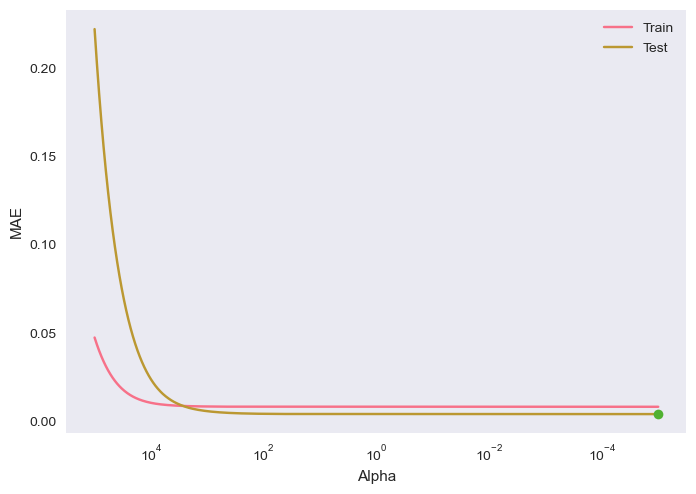

In [30]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_1, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_1, label = 'Test')

ax.plot(finally_alpha_1, mae_test_ridge_1[np.argmin(mae_test_ridge_1)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [31]:
ridge = Ridge(alpha = finally_alpha_1, max_iter=1000, tol=1e-4, random_state=42)
ridge.fit(X_1_SPY_train, y_SPY_train)
y_SPY_1_predict = ridge.predict(X_1_SPY_test)

In [32]:
spy_base_mae = mean_absolute_error(y_SPY_test, y_SPY_1_predict)
spy_base_r2 = r2_score(y_SPY_test, y_SPY_1_predict)
spy_base_sign_acc = sign_accuracy(y_SPY_test, y_SPY_1_predict)
print(f'Base MAE: {spy_base_mae}')
print(f'Base R2: {spy_base_r2}')
print(f'Base Sign Accuracy: {spy_base_sign_acc}')

Base MAE: 0.004305543453408815
Base R2: 0.9983041715771898
Base Sign Accuracy: 1.0


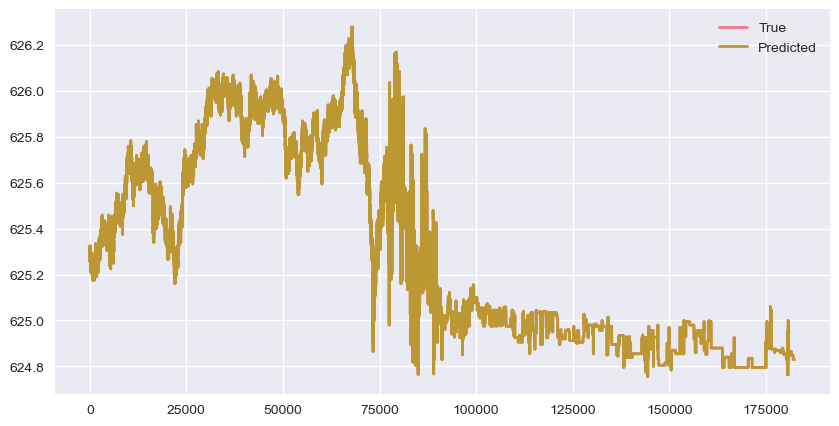

In [290]:
plt.figure(figsize=(10, 5))

plt.plot(y_SPY_test.values, label="True", linewidth=2)
plt.plot(y_SPY_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Pipeline for SPY

In [73]:
best_model_SPY_elnet, search_SPY_elnet = tune_elasticnet(X_2_SPY_train, y_SPY_train)
y_SPY_2_predict = best_model_SPY_elnet.predict(X_2_SPY_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [87]:
best_model_SPY_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=0.0008731907739399204,
                                                      l1_ratio=0.8795975452591109,
                                                      max_iter=15000,
                                                      random_state=42,
                                                      selection='random'),
                                 max_features=10, threshold=1e-08)),
                ('model',
                 ElasticNet(alpha=0.00016834549246003488,
                            l1_ratio=0.9507143064099162, max_iter=30000,
                            random_state=42))])

In [75]:
spy_elnet_mae = mean_absolute_error(y_SPY_test, y_SPY_2_predict)
spy_elnet_r2 = r2_score(y_SPY_test, y_SPY_2_predict)
spy_elnet_sign_acc = sign_accuracy(y_SPY_test, y_SPY_2_predict)
print(f'Elastic Net MAE: {spy_elnet_mae}')
print(f'Elastic Net R2: {spy_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {spy_elnet_sign_acc}')

Elastic Net MAE: 0.004577768547834939
Elastic Net R2: 0.9984699618111738
Elastic Net Sign Accuracy: 1.0


In [81]:
selected_spy_elnet = get_selected_features(best_model_SPY_elnet, X_2_SPY_train)
print(f'Selected features: {selected_spy_elnet}')

Selected features: ['mid_SPY', 'mid_QQQ', 'best_bid_SPY', 'best_ask_SPY', 'diff_mid_SPY', 'mid_changes_SPY', 'spread_SPY', 'spread_changes_SPY', 'dist_mid_A_SPY', 'dist_mid_B_SPY']


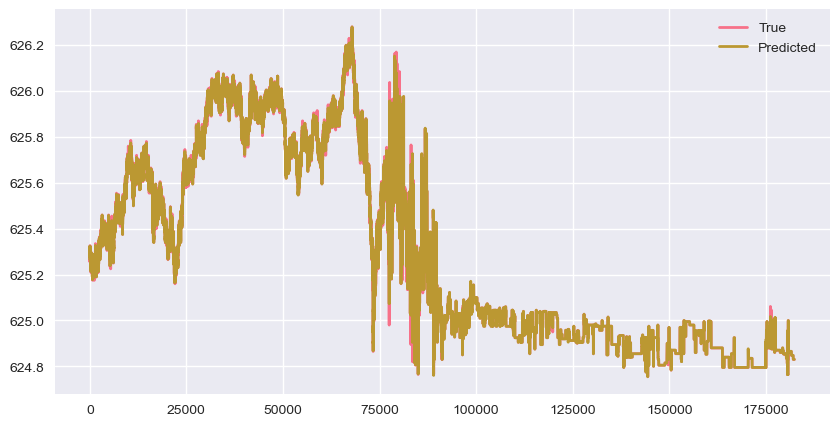

In [85]:
plt.figure(figsize=(10, 5))

plt.plot(y_SPY_test.values, label="True", linewidth=2)
plt.plot(y_SPY_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Baseline for QQQ

In [64]:
coefs_ridge_2 = []   
mae_train_ridge_2 = [] 
mae_test_ridge_2 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_QQQ_train, y_QQQ_train)
    coefs_ridge_2.append(ridge.coef_)
    mae_train_ridge_2.append(mean_absolute_error(y_QQQ_train, ridge.predict(X_1_QQQ_train)))
    mae_test_ridge_2.append(mean_absolute_error(y_QQQ_test, ridge.predict(X_1_QQQ_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [65]:
finally_alpha_2 = alphas_ridge[np.argmin(mae_test_ridge_2)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.00571510721883682,
 0.20857466173517933)

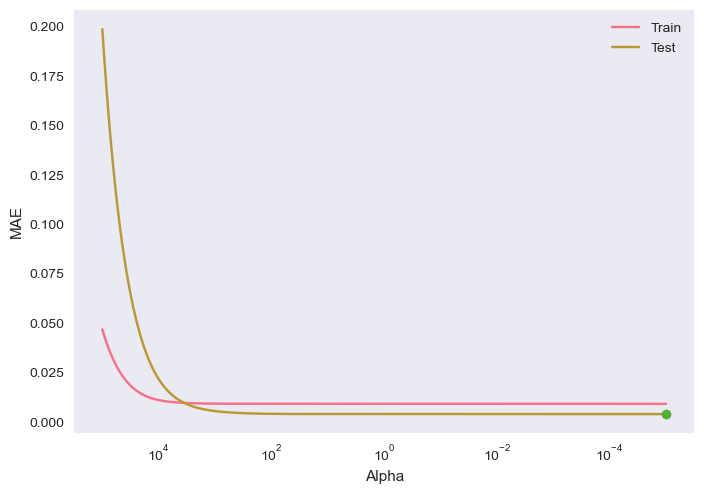

In [66]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_2, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_2, label = 'Test')

ax.plot(finally_alpha_2, mae_test_ridge_2[np.argmin(mae_test_ridge_2)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [67]:
ridge_2 = Ridge(alpha = finally_alpha_2, max_iter=1000, tol=1e-4, random_state=42)
ridge_2.fit(X_1_QQQ_train, y_QQQ_train)
y_QQQ_1_predict = ridge_2.predict(X_1_QQQ_test)

In [68]:
qqq_base_mae = mean_absolute_error(y_QQQ_test, y_QQQ_1_predict)
qqq_base_r2 = r2_score(y_QQQ_test, y_QQQ_1_predict)
qqq_base_sign_acc = sign_accuracy(y_QQQ_test, y_QQQ_1_predict)
print(f'Ridge MAE: {qqq_base_mae}')
print(f'Ridge R2: {qqq_base_r2}')
print(f'Ridge Sign Accuracy: {qqq_base_sign_acc}')

Ridge MAE: 0.00402533682452755
Ridge R2: 0.9987795955778292
Ridge Sign Accuracy: 1.0


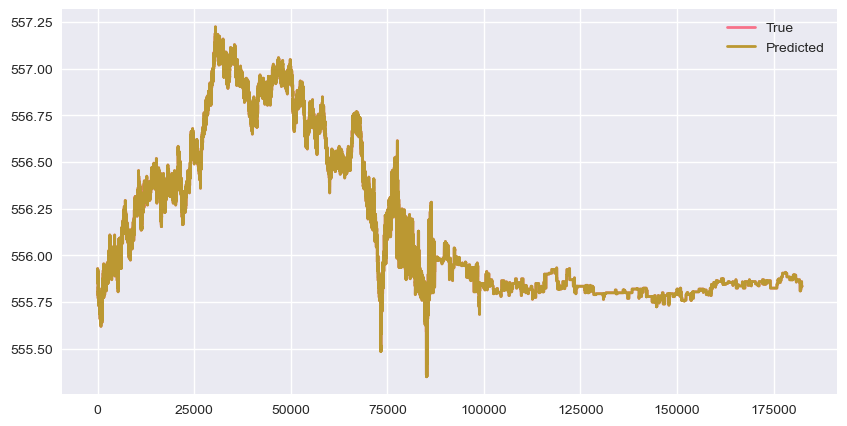

In [69]:
plt.figure(figsize=(10, 5))

plt.plot(y_QQQ_test.values, label="True", linewidth=2)
plt.plot(y_QQQ_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Pipeline for QQQ

In [181]:
best_model_QQQ_elnet, search_QQQ_elnet = tune_elasticnet(X_2_QQQ_train, y_QQQ_train)
y_QQQ_2_predict = best_model_QQQ_elnet.predict(X_2_QQQ_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [155]:
best_model_QQQ_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=0.0008731907739399204,
                                                      l1_ratio=0.8795975452591109,
                                                      max_iter=15000,
                                                      random_state=42,
                                                      selection='random'),
                                 max_features=10, threshold=1e-08)),
                ('model',
                 ElasticNet(alpha=0.00016834549246003488,
                            l1_ratio=0.9507143064099162, max_iter=30000,
                            random_state=42))])

In [157]:
qqq_elnet_mae = mean_absolute_error(y_QQQ_test, y_QQQ_2_predict)
qqq_elnet_r2 = r2_score(y_QQQ_test, y_QQQ_2_predict)
qqq_elnet_sign_acc = sign_accuracy(y_QQQ_test, y_QQQ_2_predict)
print(f'Elastic Net MAE: {qqq_elnet_mae}')
print(f'Elastic Net R2: {qqq_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {qqq_elnet_sign_acc}')

Elastic Net MAE: 0.004479849818181567
Elastic Net R2: 0.9989374340573093
Elastic Net Sign Accuracy: 1.0


In [159]:
selected_qqq_elnet = get_selected_features(best_model_QQQ_elnet, X_2_QQQ_train)
print(f'Selected features: {selected_qqq_elnet}')

Selected features: ['mid_QQQ', 'best_bid_QQQ', 'best_ask_QQQ', 'diff_mid_QQQ', 'mid_changes_QQQ', 'spread_QQQ', 'spread_changes_QQQ', 'dist_mid_A_QQQ', 'dist_mid_B_QQQ', 'trade_price_B_QQQ']


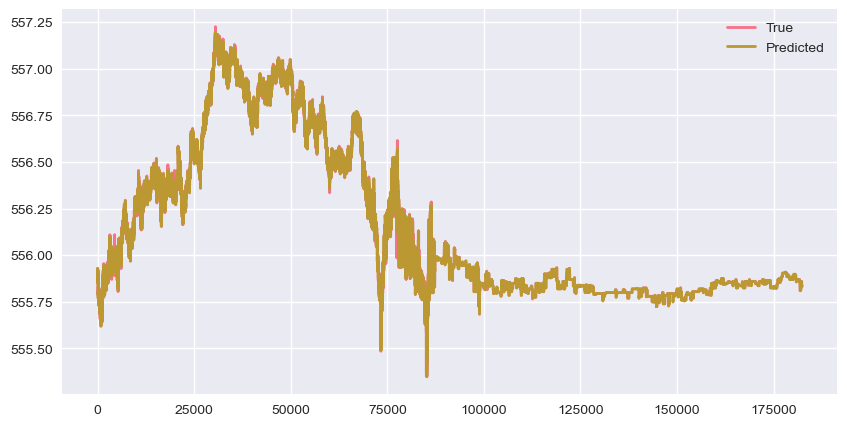

In [161]:
plt.figure(figsize=(10, 5))

plt.plot(y_QQQ_test.values, label="True", linewidth=2)
plt.plot(y_QQQ_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Baseline for VXX

In [70]:
coefs_ridge_3 = []   
mae_train_ridge_3 = [] 
mae_test_ridge_3 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_VXX_train, y_VXX_train)
    coefs_ridge_3.append(ridge.coef_)
    mae_train_ridge_3.append(mean_absolute_error(y_VXX_train, ridge.predict(X_1_VXX_train)))
    mae_test_ridge_3.append(mean_absolute_error(y_VXX_test, ridge.predict(X_1_VXX_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [71]:
finally_alpha_3 = alphas_ridge[np.argmin(mae_test_ridge_3)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.011403768052490812,
 0.25453581269361086)

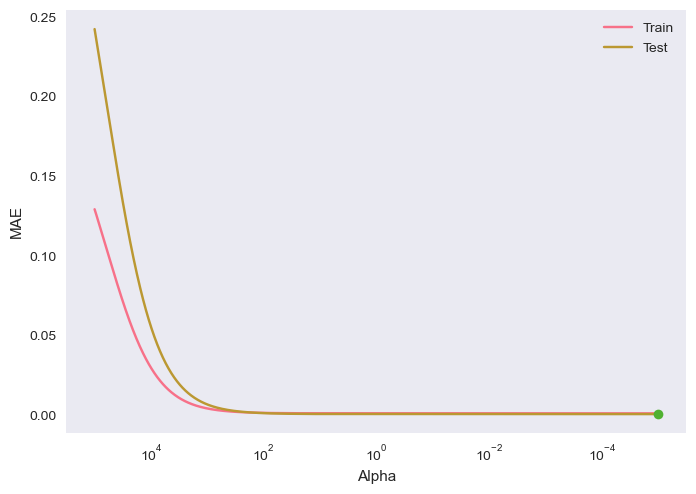

In [72]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_3, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_3, label = 'Test')

ax.plot(finally_alpha_3, mae_test_ridge_3[np.argmin(mae_test_ridge_3)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [73]:
ridge_3 = Ridge(alpha = finally_alpha_3, max_iter=1000, tol=1e-4, random_state=42)
ridge_3.fit(X_1_VXX_train, y_VXX_train)
y_VXX_1_predict = ridge_3.predict(X_1_VXX_test)

In [74]:
vxx_base_mae = mean_absolute_error(y_VXX_test, y_VXX_1_predict)
vxx_base_r2 = r2_score(y_VXX_test, y_VXX_1_predict)
vxx_base_sign_acc = sign_accuracy(y_VXX_test, y_VXX_1_predict)
print(f'Ridge MAE: {vxx_base_mae}')
print(f'Ridge R2: {vxx_base_r2}')
print(f'Ridge Sign Accuracy: {vxx_base_sign_acc}')

Ridge MAE: 0.0006843947086956286
Ridge R2: 0.9993877368846146
Ridge Sign Accuracy: 1.0


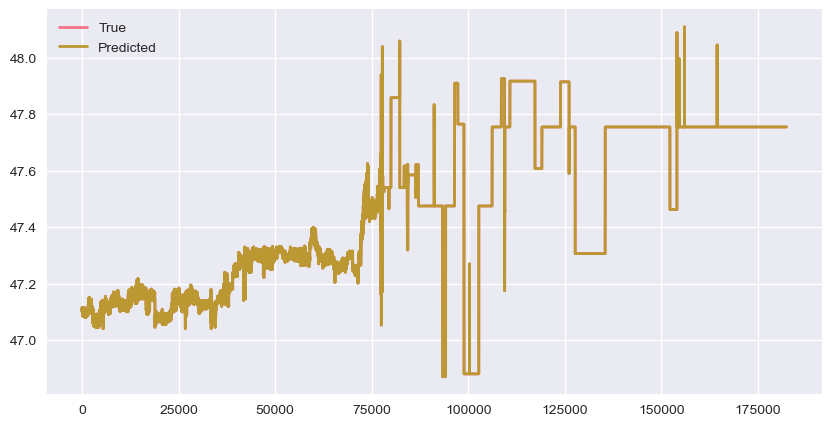

In [75]:
plt.figure(figsize=(10, 5))

plt.plot(y_VXX_test.values, label="True", linewidth=2)
plt.plot(y_VXX_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Pipeline for VXX

In [100]:
best_model_VXX_elnet, search_VXX_elnet = tune_elasticnet(X_2_VXX_train, y_VXX_train)
y_VXX_2_predict = best_model_VXX_elnet.predict(X_2_VXX_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [147]:
best_model_VXX_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=0.002170283953699624,
                                                      l1_ratio=0.942436113869325,
                                                      max_iter=15000,
                                                      random_state=42,
                                                      selection='random'),
                                 max_features=6, threshold=1e-09)),
                ('model',
                 ElasticNet(alpha=0.00011392634396035235,
                            l1_ratio=0.16122128725400442, max_iter=30000,
                            random_state=42))])

In [149]:
vxx_elnet_mae = mean_absolute_error(y_VXX_test, y_VXX_2_predict)
vxx_elnet_r2 = r2_score(y_VXX_test, y_VXX_2_predict)
vxx_elnet_sign_acc = sign_accuracy(y_VXX_test, y_VXX_2_predict)
print(f'Elastic Net MAE: {vxx_elnet_mae}')
print(f'Elastic Net R2: {vxx_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {vxx_elnet_sign_acc}')

Elastic Net MAE: 0.0007568752477020739
Elastic Net R2: 0.999387679528179
Elastic Net Sign Accuracy: 1.0


In [151]:
selected_vxx_elnet = get_selected_features(best_model_VXX_elnet, X_2_VXX_train)
print(f'Selected features: {selected_vxx_elnet}')

Selected features: ['mid_VXX', 'best_bid_VXX', 'best_ask_VXX']


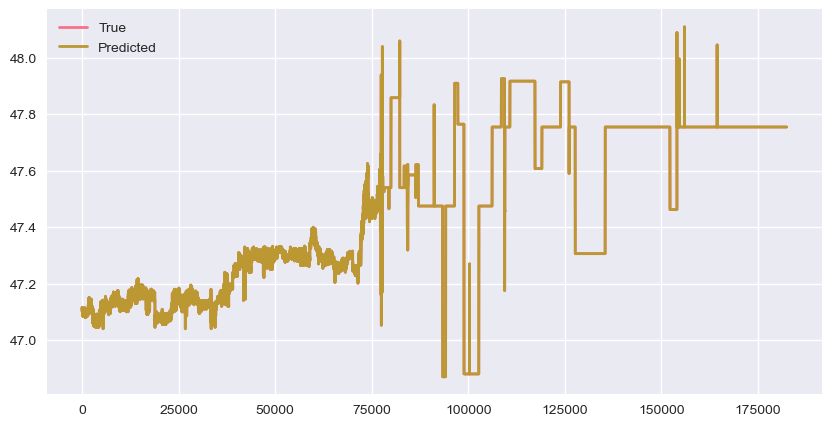

In [153]:
plt.figure(figsize=(10, 5))

plt.plot(y_VXX_test.values, label="True", linewidth=2)
plt.plot(y_VXX_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Baseline for VRSK

In [76]:
coefs_ridge_4 = []   
mae_train_ridge_4 = [] 
mae_test_ridge_4 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_VRSK_train, y_VRSK_train)
    coefs_ridge_4.append(ridge.coef_)
    mae_train_ridge_4.append(mean_absolute_error(y_VRSK_train, ridge.predict(X_1_VRSK_train)))
    mae_test_ridge_4.append(mean_absolute_error(y_VRSK_test, ridge.predict(X_1_VRSK_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [77]:
finally_alpha_4 = alphas_ridge[np.argmin(mae_test_ridge_4)]

Text(0, 0.5, 'MAE')

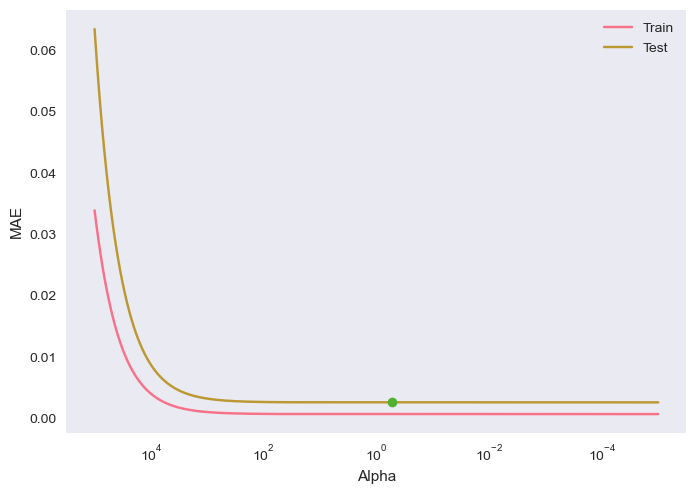

In [78]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_4, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_4, label = 'Test')

ax.plot(finally_alpha_4, mae_test_ridge_4[np.argmin(mae_test_ridge_4)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")

In [79]:
ridge_4 = Ridge(alpha = finally_alpha_4, max_iter=1000, tol=1e-4, random_state=42)
ridge_4.fit(X_1_VRSK_train, y_VRSK_train)
y_VRSK_1_predict = ridge_4.predict(X_1_VRSK_test)

In [80]:
vrsk_base_mae = mean_absolute_error(y_VRSK_test, y_VRSK_1_predict)
vrsk_base_r2 = r2_score(y_VRSK_test, y_VRSK_1_predict)
vrsk_base_sign_acc = sign_accuracy(y_VRSK_test, y_VRSK_1_predict)
print(f'Base MAE: {vrsk_base_mae}')
print(f'Base R2: {vrsk_base_r2}')
print(f'Base Sign Accuracy: {vrsk_base_sign_acc}')

Base MAE: 0.002630621394783118
Base R2: 0.9986719613733931
Base Sign Accuracy: 1.0


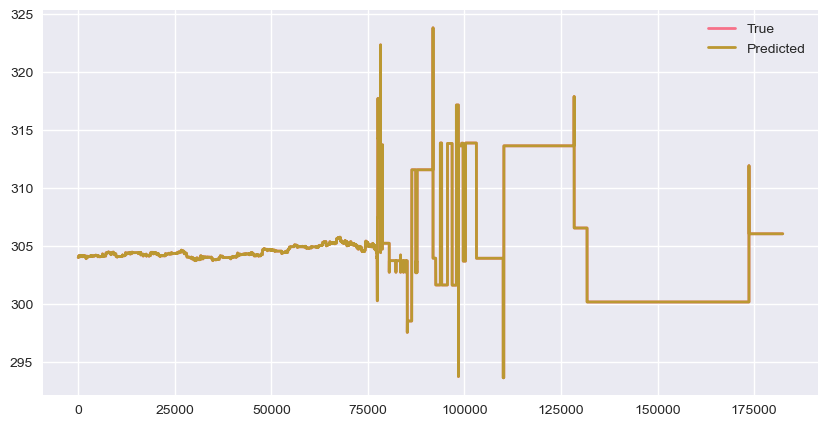

In [81]:
plt.figure(figsize=(10, 5))

plt.plot(y_VRSK_test.values, label="True", linewidth=2)
plt.plot(y_VRSK_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Pipeline for VRSK

In [101]:
best_model_VRSK_elnet, search_VRSK_elnet = tune_elasticnet(X_2_VRSK_train, y_VRSK_train)
y_VRSK_2_predict = best_model_VRSK_elnet.predict(X_2_VRSK_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [135]:
best_model_VRSK_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=0.002170283953699624,
                                                      l1_ratio=0.942436113869325,
                                                      max_iter=15000,
                                                      random_state=42,
                                                      selection='random'),
                                 max_features=6, threshold=1e-09)),
                ('model',
                 ElasticNet(alpha=0.00011392634396035235,
                            l1_ratio=0.16122128725400442, max_iter=30000,
                            random_state=42))])

In [141]:
vrsk_elnet_mae = mean_absolute_error(y_VRSK_test, y_VRSK_2_predict)
vrsk_elnet_r2 = r2_score(y_VRSK_test, y_VRSK_2_predict)
vrsk_elnet_sign_acc = sign_accuracy(y_VRSK_test, y_VRSK_2_predict)
print(f'Elastic Net MAE: {vrsk_elnet_mae}')
print(f'Elastic Net R2: {vrsk_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {vrsk_elnet_sign_acc}')

Elastic Net MAE: 0.0071174763828281504
Elastic Net R2: 0.9986696649842577
Elastic Net Sign Accuracy: 1.0


In [143]:
selected_vrsk_elnet = get_selected_features(best_model_VRSK_elnet, X_2_VRSK_train)
print(f'Selected features: {selected_vrsk_elnet}')

Selected features: ['mid_VRSK', 'best_bid_VRSK', 'best_ask_VRSK', 'spread_VRSK', 'rel_spread_VRSK']


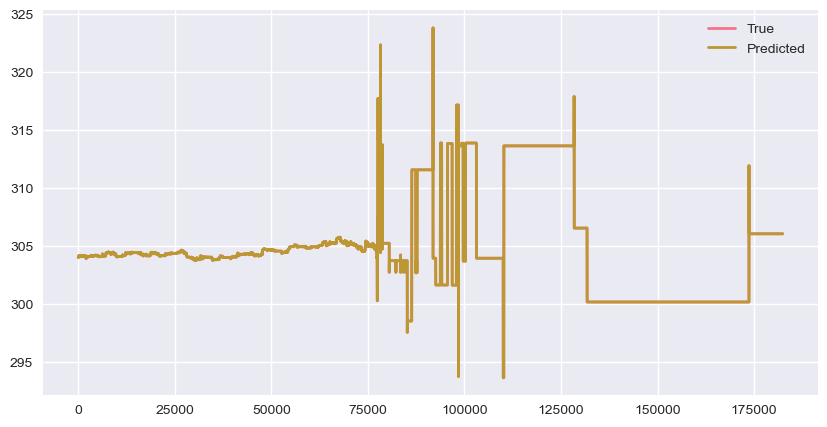

In [145]:
plt.figure(figsize=(10, 5))

plt.plot(y_VRSK_test.values, label="True", linewidth=2)
plt.plot(y_VRSK_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Baseline for MRVL

In [82]:
coefs_ridge_5 = []   
mae_train_ridge_5 = [] 
mae_test_ridge_5 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_MRVL_train, y_MRVL_train)
    coefs_ridge_5.append(ridge.coef_)
    mae_train_ridge_5.append(mean_absolute_error(y_MRVL_train, ridge.predict(X_1_MRVL_train)))
    mae_test_ridge_5.append(mean_absolute_error(y_MRVL_test, ridge.predict(X_1_MRVL_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [83]:
finally_alpha_5 = alphas_ridge[np.argmin(mae_test_ridge_5)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.005942982017907862,
 0.1468209472387871)

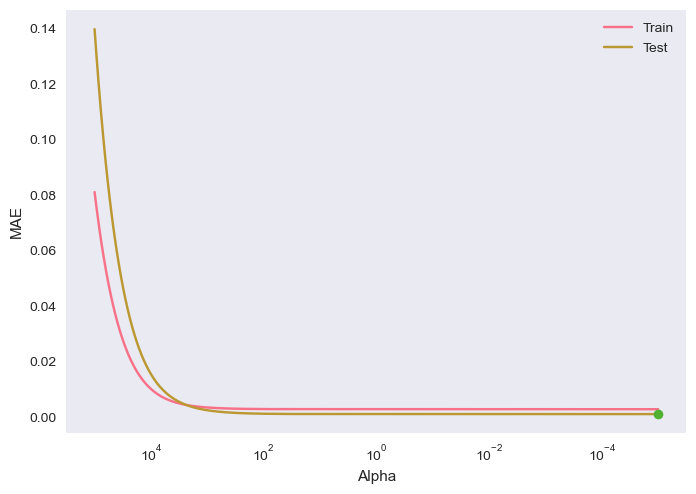

In [84]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_5, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_5, label = 'Test')

ax.plot(finally_alpha_5, mae_test_ridge_5[np.argmin(mae_test_ridge_5)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [85]:
ridge_5 = Ridge(alpha = finally_alpha_5, max_iter=1000, tol=1e-4, random_state=42)
ridge_5.fit(X_1_MRVL_train, y_MRVL_train)
y_MRVL_1_predict = ridge_5.predict(X_1_MRVL_test)

In [86]:
mrvl_base_mae = mean_absolute_error(y_MRVL_test, y_MRVL_1_predict)
mrvl_base_r2 = r2_score(y_MRVL_test, y_MRVL_1_predict)
mrvl_base_sign_acc = sign_accuracy(y_MRVL_test, y_MRVL_1_predict)
print(f'Base MAE: {mrvl_base_mae}')
print(f'Base R2: {mrvl_base_r2}')
print(f'Base Sign Accuracy: {mrvl_base_sign_acc}')

Base MAE: 0.0010008329483055453
Base R2: 0.9980165565965491
Base Sign Accuracy: 1.0


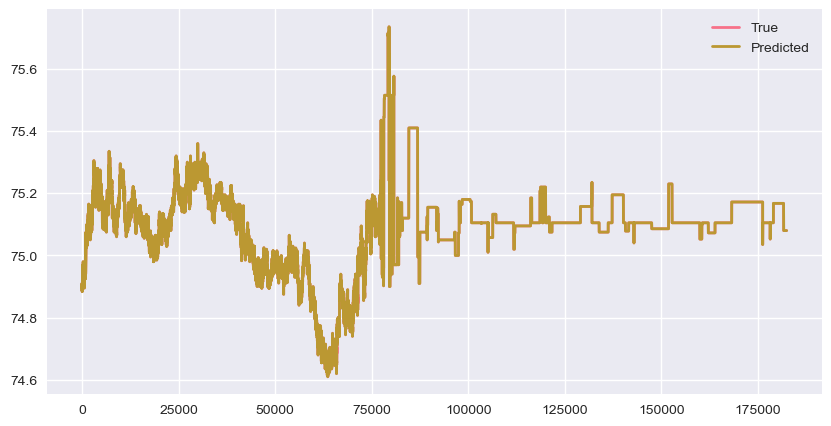

In [87]:
plt.figure(figsize=(10, 5))

plt.plot(y_MRVL_test.values, label="True", linewidth=2)
plt.plot(y_MRVL_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Pipeline for MRVL

In [102]:
best_model_MRVL_elnet, search_MRVL_elnet = tune_elasticnet(X_2_MRVL_train, y_MRVL_train)
y_MRVL_2_predict = best_model_MRVL_elnet.predict(X_2_MRVL_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [127]:
best_model_MRVL_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=0.00012759487091372598,
                                                      l1_ratio=0.8525712073494107,
                                                      max_iter=15000,
                                                      random_state=42,
                                                      selection='random'),
                                 max_features=8, threshold=1e-09)),
                ('model',
                 ElasticNet(alpha=3.467205844880958e-05,
                            l1_ratio=0.6364104112637804, max_iter=30000,
                            random_state=42))])

In [129]:
mrvl_elnet_mae = mean_absolute_error(y_MRVL_test, y_MRVL_2_predict)
mrvl_elnet_r2 = r2_score(y_MRVL_test, y_MRVL_2_predict)
mrvl_elnet_sign_acc = sign_accuracy(y_MRVL_test, y_MRVL_2_predict)
print(f'Elastic Net MAE: {mrvl_elnet_mae}')
print(f'Elastic Net R2: {mrvl_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {mrvl_elnet_sign_acc}')

Elastic Net MAE: 0.001645302046390831
Elastic Net R2: 0.997936780815172
Elastic Net Sign Accuracy: 1.0


In [131]:
selected_mrvl_elnet = get_selected_features(best_model_MRVL_elnet, X_2_MRVL_train)
print(f'Selected features: {selected_mrvl_elnet}')

Selected features: ['best_ask_MRVL', 'spread_MRVL', 'vwap_L5_MRVL', 'dist_mid_A_MRVL', 'dist_mid_B_MRVL', 'microprice_MRVL', 'trade_price_A_MRVL', 'trade_price_B_MRVL']


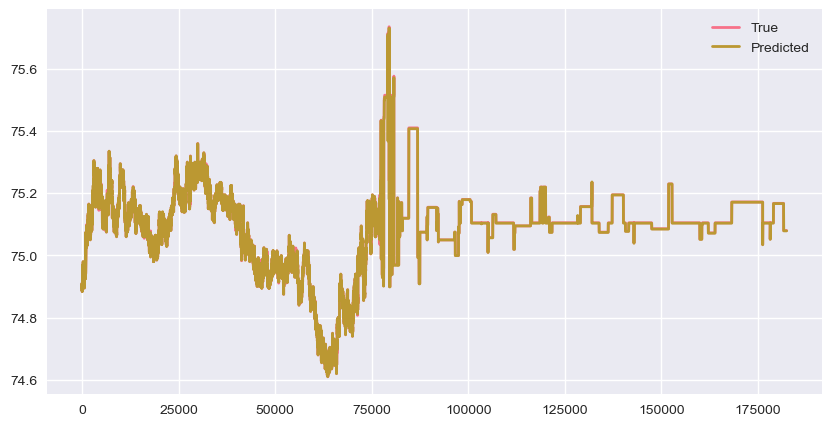

In [133]:
plt.figure(figsize=(10, 5))

plt.plot(y_MRVL_test.values, label="True", linewidth=2)
plt.plot(y_MRVL_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Baseline for ANSS

In [88]:
coefs_ridge_6 = []   
mae_train_ridge_6 = [] 
mae_test_ridge_6 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_ANSS_train, y_ANSS_train)
    coefs_ridge_6.append(ridge.coef_)
    mae_train_ridge_6.append(mean_absolute_error(y_ANSS_train, ridge.predict(X_1_ANSS_train)))
    mae_test_ridge_6.append(mean_absolute_error(y_ANSS_test, ridge.predict(X_1_ANSS_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [89]:
finally_alpha_6 = alphas_ridge[np.argmin(mae_test_ridge_6)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.008088555039894913,
 0.18994217045987888)

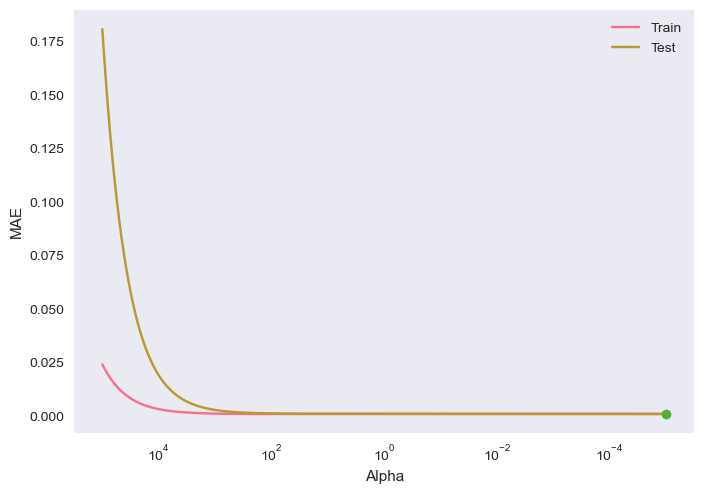

In [90]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_6, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_6, label = 'Test')

ax.plot(finally_alpha_6, mae_test_ridge_6[np.argmin(mae_test_ridge_6)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [93]:
ridge_6 = Ridge(alpha = finally_alpha_6, max_iter=1000, tol=1e-4, random_state=42)
ridge_6.fit(X_1_ANSS_train, y_ANSS_train)
y_ANSS_1_predict = ridge_6.predict(X_1_ANSS_test)

In [98]:
anss_base_mae = mean_absolute_error(y_ANSS_test, y_ANSS_1_predict)
anss_base_r2 = r2_score(y_ANSS_test, y_ANSS_1_predict)
anss_base_sign_acc = sign_accuracy(y_ANSS_test, y_ANSS_1_predict)
print(f'Base MAE: {anss_base_mae}')
print(f'Base R2: {anss_base_r2}')
print(f'Base Sign Accuracy: {anss_base_sign_acc}')

Base MAE: 0.0010502003157483663
Base R2: 0.9998884563969366
Base Sign Accuracy: 1.0


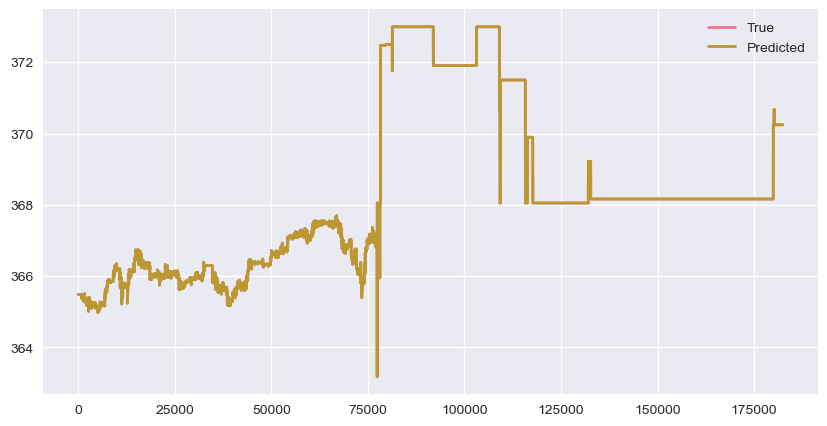

In [99]:
plt.figure(figsize=(10, 5))

plt.plot(y_ANSS_test.values, label="True", linewidth=2)
plt.plot(y_ANSS_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Pipeline for ANSS

In [103]:
best_model_ANSS_elnet, search_ANSS_elnet = tune_elasticnet(X_2_ANSS_train, y_ANSS_train)
y_ANSS_2_predict = best_model_ANSS_elnet.predict(X_2_ANSS_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [119]:
best_model_ANSS_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=0.00033622818635581673,
                                                      l1_ratio=0.8295835055926347,
                                                      max_iter=15000,
                                                      random_state=42,
                                                      selection='random'),
                                 max_features=6, threshold=1e-09)),
                ('model',
                 ElasticNet(alpha=6.981203125151329e-05,
                            l1_ratio=0.3042422429595377, max_iter=30000,
                            random_state=42))])

In [121]:
anss_elnet_mae = mean_absolute_error(y_ANSS_test, y_ANSS_2_predict)
anss_elnet_r2 = r2_score(y_ANSS_test, y_ANSS_2_predict)
anss_elnet_sign_acc = sign_accuracy(y_ANSS_test, y_ANSS_2_predict)
print(f'Elastic Net MAE: {anss_elnet_mae}')
print(f'Elastic Net R2: {anss_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {anss_elnet_sign_acc}')

Elastic Net MAE: 0.0022527840669402154
Elastic Net R2: 0.9998880153173632
Elastic Net Sign Accuracy: 1.0


In [123]:
selected_anss_elnet = get_selected_features(best_model_ANSS_elnet, X_2_ANSS_train)
print(f'Selected features: {selected_anss_elnet}')

Selected features: ['mid_ANSS', 'best_bid_ANSS', 'best_ask_ANSS', 'spread_ANSS', 'vwap_L5_ANSS', 'microprice_ANSS']


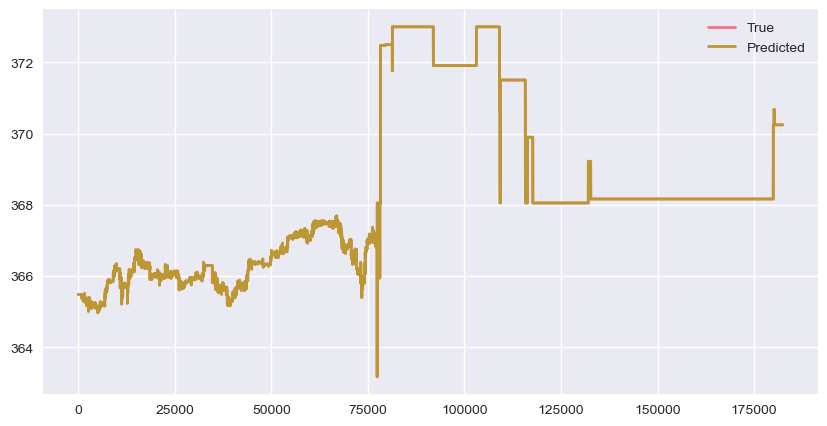

In [125]:
plt.figure(figsize=(10, 5))

plt.plot(y_ANSS_test.values, label="True", linewidth=2)
plt.plot(y_ANSS_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Baseline for FAST

In [100]:
coefs_ridge_7 = []   
mae_train_ridge_7 = [] 
mae_test_ridge_7 = [] 

for i, a in enumerate(alphas_ridge):
    if i % 100 == 0:
        print(f"Processing {i+1}/{len(alphas_ridge)}, Alpha = {a:.6f}")
    ridge = Ridge(alpha = a, max_iter=1000,
    tol=1e-4, random_state=42)
    ridge.fit(X_1_FAST_train, y_FAST_train)
    coefs_ridge_7.append(ridge.coef_)
    mae_train_ridge_7.append(mean_absolute_error(y_FAST_train, ridge.predict(X_1_FAST_train)))
    mae_test_ridge_7.append(mean_absolute_error(y_FAST_test, ridge.predict(X_1_FAST_test)))

Processing 1/1000, Alpha = 0.000010
Processing 101/1000, Alpha = 0.000100
Processing 201/1000, Alpha = 0.001005
Processing 301/1000, Alpha = 0.010069
Processing 401/1000, Alpha = 0.100926
Processing 501/1000, Alpha = 1.011591
Processing 601/1000, Alpha = 10.139254
Processing 701/1000, Alpha = 101.626509
Processing 801/1000, Alpha = 1018.610170
Processing 901/1000, Alpha = 10209.606623


In [101]:
finally_alpha_7 = alphas_ridge[np.argmin(mae_test_ridge_7)]

(316227.7660168379,
 3.162277660168379e-06,
 -0.012091426003654126,
 0.2600715219308015)

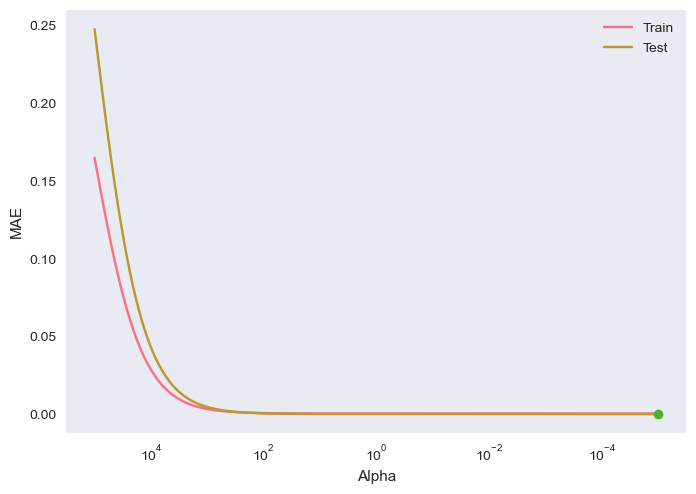

In [102]:
ax = plt.gca()

ax.plot(alphas_ridge, mae_train_ridge_7, label = 'Train')
ax.plot(alphas_ridge, mae_test_ridge_7, label = 'Test')

ax.plot(finally_alpha_7, mae_test_ridge_7[np.argmin(mae_test_ridge_7)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  

ax.legend()
ax.grid()

plt.xlabel("Alpha")
plt.ylabel("MAE")
plt.axis("tight")

In [103]:
ridge_7 = Ridge(alpha = finally_alpha_7, max_iter=1000, tol=1e-4, random_state=42)
ridge_7.fit(X_1_FAST_train, y_FAST_train)
y_FAST_1_predict = ridge_7.predict(X_1_FAST_test)

In [104]:
fast_base_mae = mean_absolute_error(y_FAST_test, y_FAST_1_predict)
fast_base_r2 = r2_score(y_FAST_test, y_FAST_1_predict)
fast_base_sign_acc = sign_accuracy(y_FAST_test, y_FAST_1_predict)
print(f'Base MAE: {fast_base_mae}')
print(f'Base R2: {fast_base_r2}')
print(f'Base Sign Accuracy: {fast_base_sign_acc}')

Base MAE: 0.0002796170842756736
Base R2: 0.9990052862729538
Base Sign Accuracy: 1.0


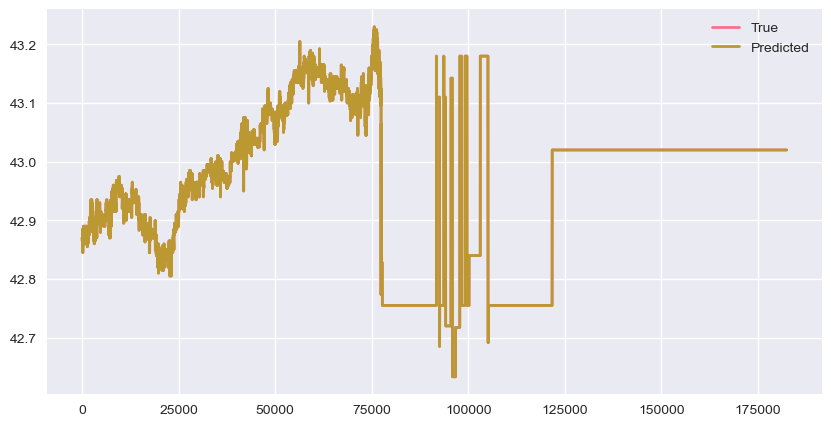

In [105]:
plt.figure(figsize=(10, 5))

plt.plot(y_FAST_test.values, label="True", linewidth=2)
plt.plot(y_FAST_1_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

### Pipeline for FAST

In [104]:
best_model_FAST_elnet, search_FAST_elnet = tune_elasticnet(X_2_FAST_train, y_FAST_train)
y_FAST_2_predict = best_model_FAST_elnet.predict(X_2_FAST_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [111]:
best_model_FAST_elnet

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('select',
                 SelectFromModel(estimator=ElasticNet(alpha=0.0016198453229362285,
                                                      l1_ratio=0.8803345035229626,
                                                      max_iter=15000,
                                                      random_state=42,
                                                      selection='random'),
                                 max_features=12, threshold=1e-09)),
                ('model',
                 ElasticNet(alpha=6.153331256530186e-05,
                            l1_ratio=0.05808361216819946, max_iter=30000,
                            random_state=42))])

In [113]:
fast_elnet_mae = mean_absolute_error(y_FAST_test, y_FAST_2_predict)
fast_elnet_r2 = r2_score(y_FAST_test, y_FAST_2_predict)
fast_elnet_sign_acc = sign_accuracy(y_FAST_test, y_FAST_2_predict)
print(f'Elastic Net MAE: {fast_elnet_mae}')
print(f'Elastic Net R2: {fast_elnet_r2}')
print(f'Elastic Net Sign Accuracy: {fast_elnet_sign_acc}')

Elastic Net MAE: 0.000316426236620806
Elastic Net R2: 0.9990049629864652
Elastic Net Sign Accuracy: 1.0


In [115]:
selected_fast_elnet = get_selected_features(best_model_FAST_elnet, X_2_FAST_train)
print(f'Selected features: {selected_fast_elnet}')

Selected features: ['mid_FAST', 'best_bid_FAST', 'best_ask_FAST']


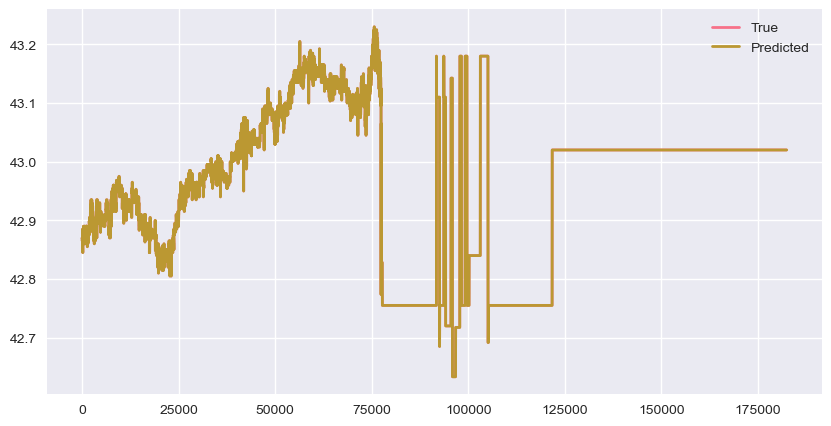

In [117]:
plt.figure(figsize=(10, 5))

plt.plot(y_FAST_test.values, label="True", linewidth=2)
plt.plot(y_FAST_2_predict, label="Predicted", linewidth=2)


plt.legend()
plt.grid(True)
plt.show()

Вывод: на данных мидпрайса немного лучше себя показала ридж-регрессия на собственном лаговом значении и имбалансе лучшего уровня. Учитывая высокую частотность данных и сложность алгоритма (плюс, волатильность можно обновлять реже, а мидпрайс нам нужен каждые 100 мс), мы остановимся только на этих фичах, так как они просты в расчёте и довольно информативны. Лаги и фичи других инструментов включаться в модель не будут, так как ввиду отсутствия цепочки следования инструментов, они только создают шум в данных.

In [69]:
# joblib.dump({'model': ridge, 'features': ['lob_imbalance_L1_SPY', 'mid_SPY']}, 'mid_SPY.joblib')

In [55]:
# joblib.dump({'model': ridge_2, 'features': ['lob_imbalance_L1_QQQ', 'mid_QQQ']}, 'mid_QQQ.joblib')

In [57]:
# joblib.dump({'model': ridge_3, 'features': ['lob_imbalance_L1_VXX', 'mid_VXX']}, 'mid_VXX.joblib')

In [59]:
# joblib.dump({'model': ridge_4, 'features': ['lob_imbalance_L1_VRSK', 'mid_VRSK']}, 'mid_VRSK.joblib')

In [61]:
# joblib.dump({'model': ridge_5, 'features': ['lob_imbalance_L1_MRVL', 'mid_MRVL']}, 'mid_MRVL.joblib')

In [63]:
# joblib.dump({'model': ridge_6, 'features': ['lob_imbalance_L1_ANSS', 'mid_ANSS']}, 'mid_ANSS.joblib')

In [65]:
# joblib.dump({'model': ridge_7, 'features': ['lob_imbalance_L1_FAST', 'mid_FAST']}, 'mid_FAST.joblib')